<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1

Error al cargar el fichero tablero, usando tablero aleatorio...
Error al cargar el fichero secuencia, usando secuencia aleatoria...
Que empiece el juego:😉


,0,1,2,3,4,5
A,.,.,.,.,1,.
B,b,.,a,a,.,.
C,a,a,a,a,.,.
D,.,.,.,.,.,a
E,b,.,.,.,.,1
F,b,.,a,.,a,a



Turno: 0 Puntos:-25
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,.,1,.
B,b,.,.,.,.,.
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,.,1
F,.,.,a,.,a,a



Turno: 1 Puntos:-16
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,.,.,.,.,1
B,b,.,.,.,.,.
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,a,.,a,a



Turno: 2 Puntos:9
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,.,.,.
B,b,.,.,.,.,1
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 3 Puntos:11
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,.,a,1
B,b,.,.,.,.,.
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 4 Puntos:12
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,.,.,.,a,.
B,b,.,.,.,1,1
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 5 Puntos:-13
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,a,a,1
B,b,.,.,.,.,1
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 6 Puntos:-12
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,.,1,1
B,b,.,.,.,b,.
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 7 Puntos:-9
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,a,1,.,.
B,b,.,.,.,b,1
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 8 Puntos:-8
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,a,a,.,1,1
B,b,.,.,.,b,.
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 9 Puntos:-7
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,b,.,.,1,.,.
B,b,.,.,.,b,1
C,.,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 10 Puntos:-4
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,.,.,.,1,1
B,.,.,.,.,b,.
C,c,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 11 Puntos:11
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,a,1,.
B,.,.,.,.,b,1
C,c,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 12 Puntos:12
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,a,2,a
B,.,.,.,.,b,.
C,c,.,.,.,.,1
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 13 Puntos:33
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,a,a,2,a
B,.,.,.,.,b,1
C,c,.,.,.,.,.
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 14 Puntos:34
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,a,a,2,a
B,.,.,.,.,b,2
C,c,.,.,.,.,a
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 15 Puntos:55
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,.,2,a
B,.,.,.,b,b,2
C,c,.,.,.,.,a
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 16 Puntos:58
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,.,.,c,2,a
B,.,.,.,.,.,2
C,c,.,.,.,.,a
D,c,.,.,.,.,a
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 17 Puntos:73
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,c,2,a
B,.,.,.,.,.,2
C,c,.,.,.,.,.
D,c,.,.,.,b,.
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 18 Puntos:76
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,.,.,c,2,a
B,.,.,.,.,1,2
C,c,.,.,.,.,.
D,c,.,.,.,b,.
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 19 Puntos:51
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,c,2,a
B,.,.,.,.,.,2
C,c,.,.,a,1,.
D,c,.,.,.,b,.
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 20 Puntos:52
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,c,2,a
B,.,.,.,a,1,2
C,c,.,.,a,.,.
D,c,.,.,.,b,.
E,.,.,.,.,b,2
F,.,.,.,b,.,.



Turno: 21 Puntos:53
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,c,2,a
B,.,.,.,1,.,2
C,c,.,.,.,c,.
D,c,.,.,.,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 22 Puntos:66
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,.,c,2,a
B,.,.,.,.,a,2
C,c,.,.,1,c,.
D,c,.,.,.,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 23 Puntos:67
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,.,.,c,2,a
B,.,.,1,1,a,2
C,c,.,.,.,c,.
D,c,.,.,.,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 24 Puntos:42
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,a,1,c,2,a
B,.,.,.,.,a,2
C,c,.,.,1,c,.
D,c,.,.,.,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 25 Puntos:43
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,a,2,c,2,a
B,.,.,a,1,a,2
C,c,.,.,.,c,.
D,c,.,.,.,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 26 Puntos:64
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,a,2,c,2,a
B,.,.,a,2,a,2
C,c,.,.,a,c,.
D,c,.,.,.,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 27 Puntos:85
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,a,2,c,2,a
B,.,.,a,2,a,2
C,c,.,.,a,c,.
D,c,.,.,.,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 28 Puntos:86
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,a,2,c,2,a
B,.,.,a,2,a,2
C,c,.,.,a,c,b
D,c,.,.,.,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 29 Puntos:91
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,a,2,c,2,a
B,.,.,a,2,a,2
C,c,.,.,a,c,b
D,c,.,.,.,.,b
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 30 Puntos:96
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,2,c,2,a
B,.,b,.,2,a,2
C,c,.,.,a,c,b
D,c,.,.,.,.,b
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 31 Puntos:98
Almacen: [.] Actual: [c]


,0,1,2,3,4,5
A,.,.,2,c,2,a
B,d,b,.,2,a,2
C,.,.,.,a,c,b
D,.,.,.,.,.,b
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 32 Puntos:173
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,a,2,c,2,a
B,d,b,.,2,a,2
C,.,.,.,a,c,b
D,.,.,.,.,.,b
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 33 Puntos:174
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,a,2,c,2,a
B,d,b,.,2,a,2
C,.,.,.,a,c,b
D,.,.,.,.,.,b
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 34 Puntos:175
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,a,2,c,2,a
B,d,b,.,2,a,2
C,.,.,.,a,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 35 Puntos:190
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,a,a,2,c,2,a
B,d,b,b,2,a,2
C,.,.,.,a,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 36 Puntos:195
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,a,2,c,2,a
B,d,b,b,2,a,2
C,.,.,a,a,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 37 Puntos:196
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,a,a,2,c,2,a
B,d,.,.,2,a,2
C,.,c,.,.,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 38 Puntos:209
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,2,c,2,a
B,d,b,.,2,a,2
C,.,c,.,.,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 39 Puntos:212
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,1,2,c,2,a
B,d,b,.,2,a,2
C,.,c,.,.,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 40 Puntos:187
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,b,.,2,a,2
C,.,c,.,.,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 41 Puntos:267
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,b,a,2,a,2
C,.,c,.,.,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 42 Puntos:268
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,b,a,2,a,2
C,.,c,a,.,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 43 Puntos:269
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,b,.,2,a,2
C,.,c,.,b,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 44 Puntos:272
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,b,a,2,a,2
C,.,c,.,b,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 45 Puntos:273
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,b,a,2,a,2
C,.,c,a,b,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 46 Puntos:274
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,b,a,2,a,2
C,.,c,a,b,c,.
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 47 Puntos:279
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,b,a,2,a,2
C,.,c,a,b,c,a
D,.,.,.,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 48 Puntos:280
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,b,.,2,a,2
C,.,c,.,b,c,a
D,.,.,b,.,c,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 49 Puntos:283
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,b,.,2,a,2
C,.,c,.,.,.,a
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 50 Puntos:348
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,b,a,2,a,2
C,.,c,.,.,.,a
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 51 Puntos:349
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,b,a,2,a,2
C,.,c,a,.,.,a
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 52 Puntos:350
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,b,.,2,a,2
C,.,c,.,b,.,a
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 53 Puntos:353
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,b,.,2,.,2
C,.,c,.,b,b,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 54 Puntos:356
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,.,c,2,.,2
C,.,c,.,b,b,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 55 Puntos:371
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,.,.,2,.,2
C,.,.,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 56 Puntos:436
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,.,a,2,.,2
C,.,.,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 57 Puntos:437
Almacen: [.] Actual: [c]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,.,a,2,c,2
C,.,.,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 58 Puntos:462
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,.,3,c,2,a
B,d,a,a,2,c,2
C,.,.,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 59 Puntos:463
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,.,.,2,c,2
C,.,.,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 60 Puntos:466
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,.,a,2,c,2
C,.,.,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 61 Puntos:467
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,.,b,3,c,2,a
B,d,a,a,2,c,2
C,.,.,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 62 Puntos:468
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,.,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 63 Puntos:463
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,.,.,2,c,2
C,.,b,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 64 Puntos:466
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,.,a,2,c,2
C,.,b,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 65 Puntos:467
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,.,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 66 Puntos:468
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,.,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 67 Puntos:469
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,.
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 68 Puntos:470
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,.,.,b
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 69 Puntos:473
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,.,b
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 70 Puntos:474
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,.,.,d,.,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 71 Puntos:475
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,.,.,b
D,.,.,.,d,b,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 72 Puntos:478
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,.,b
D,.,.,.,d,b,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 73 Puntos:479
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,.,.,d,b,.
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 74 Puntos:480
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,.,.,d,b,a
E,.,.,.,.,.,2
F,.,.,.,b,.,.



Turno: 75 Puntos:481
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,.,.,d,b,a
E,.,.,.,.,1,2
F,.,.,.,b,.,.



Turno: 76 Puntos:456
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,.,.,d,b,a
E,.,.,.,.,.,2
F,.,.,.,b,1,a



Turno: 77 Puntos:457
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,.,.,d,b,a
E,.,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 78 Puntos:482
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,.,.,.,d,b,a
E,.,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 79 Puntos:483
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,.,.,d,b,a
E,.,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 80 Puntos:484
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,b,.,d,b,a
E,.,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 81 Puntos:487
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,.,b,.,d,b,a
E,.,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 82 Puntos:488
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,1,b,.,d,b,a
E,.,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 83 Puntos:463
Almacen: [.] Actual: [w]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,.,b,.,d,b,a
E,.,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 84 Puntos:488
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,.,d,b,a
E,.,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 85 Puntos:489
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,b,.,d,b,a
E,b,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 86 Puntos:492
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,.,b,.,d,b,a
E,b,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 87 Puntos:493
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,.,d,b,a
E,b,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 88 Puntos:494
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,a,d,b,a
E,b,.,.,.,b,2
F,.,.,.,b,2,a



Turno: 89 Puntos:495
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,a,d,b,a
E,b,.,a,.,b,2
F,.,.,.,b,2,a



Turno: 90 Puntos:496
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,.,d,a,a,b
D,a,.,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 91 Puntos:504
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,.,.,2,c,2
C,.,b,d,a,a,b
D,.,.,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 92 Puntos:505
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,.,a,2,c,2
C,.,b,d,a,a,b
D,.,.,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 93 Puntos:506
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,.,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 94 Puntos:507
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,.,.,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 95 Puntos:508
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,.,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 96 Puntos:509
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,b,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 97 Puntos:512
Almacen: [.] Actual: [w]


,0,1,2,3,4,5
A,2,b,3,c,2,.
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,b,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 98 Puntos:511
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,b,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 99 Puntos:512
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,.,b,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 100 Puntos:513
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,.,d,b,a
E,.,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 101 Puntos:514
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,.,b,d,a,a,b
D,.,b,.,d,b,a
E,b,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 102 Puntos:517
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,.,b,.,d,b,a
E,b,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 103 Puntos:518
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,.,d,b,a
E,b,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 104 Puntos:519
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,a,d,b,a
E,b,c,.,.,b,2
F,.,.,.,b,2,a



Turno: 105 Puntos:520
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,a,d,b,a
E,b,c,a,.,b,2
F,.,.,.,b,2,a



Turno: 106 Puntos:521
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,.,d,.,a
E,b,c,.,c,.,2
F,.,.,.,.,2,a



Turno: 107 Puntos:529
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,.,.,b
D,a,b,.,d,b,.
E,b,c,.,c,.,2
F,.,.,.,.,2,a



Turno: 108 Puntos:531
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,.,b
D,a,b,.,d,b,.
E,b,c,.,c,.,2
F,.,.,.,.,2,a



Turno: 109 Puntos:532
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,.,d,b,.
E,b,c,.,c,.,2
F,.,.,.,.,2,a



Turno: 110 Puntos:533
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,.,d,b,a
E,b,c,.,c,.,2
F,.,.,.,.,2,a



Turno: 111 Puntos:534
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,.,d,b,a
E,b,c,.,c,a,2
F,.,.,.,.,2,a



Turno: 112 Puntos:535
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,b,d,a,a,b
D,a,b,.,d,b,a
E,b,c,.,c,a,2
F,.,.,.,a,2,a



Turno: 113 Puntos:536
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,a,a,2,c,2
C,a,.,d,a,a,b
D,a,.,c,d,b,a
E,b,c,.,c,a,2
F,.,.,.,a,2,a



Turno: 114 Puntos:551
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,.,.,2,c,2
C,.,b,d,a,a,b
D,.,.,c,d,b,a
E,b,c,.,c,a,2
F,.,.,.,a,2,a



Turno: 115 Puntos:552
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,b,3,c,2,a
B,d,.,a,2,c,2
C,.,b,d,a,a,b
D,.,.,c,d,b,a
E,b,c,.,c,a,2
F,.,.,.,a,2,a



Turno: 116 Puntos:553
Almacen: [.] Actual: [w]


,0,1,2,3,4,5
A,2,b,3,c,2,.
B,d,.,a,2,c,2
C,.,b,d,a,a,b
D,.,.,c,d,b,a
E,b,c,.,c,a,2
F,.,.,.,a,2,a



Turno: 117 Puntos:552
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,2,.,3,c,2,.
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,.,c,d,b,a
E,b,c,.,c,a,2
F,.,.,.,a,2,a



Turno: 118 Puntos:567
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,.
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,.,c,d,b,a
E,b,c,.,c,a,2
F,.,.,.,a,2,a



Turno: 119 Puntos:568
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,.,c,d,b,a
E,b,c,.,c,a,2
F,.,.,.,a,2,a



Turno: 120 Puntos:569
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,.,c,d,b,a
E,b,c,.,c,a,2
F,.,.,a,a,2,a



Turno: 121 Puntos:570
Almacen: [.] Actual: [1]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,.,c,d,b,a
E,b,c,2,c,a,2
F,.,.,a,a,2,a



Turno: 122 Puntos:565
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,b,.,c,d,b,a
E,b,c,2,c,a,2
F,.,.,a,a,2,a



Turno: 123 Puntos:570
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,b,.,c,d,b,a
E,b,c,2,c,a,2
F,.,b,.,.,2,a



Turno: 124 Puntos:573
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,b,.,c,d,b,a
E,b,c,2,c,a,2
F,.,b,a,.,2,a



Turno: 125 Puntos:574
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,b,.,c,d,b,a
E,b,c,2,c,a,2
F,.,b,a,a,2,a



Turno: 126 Puntos:575
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,a,.,d,a,a,b
D,b,.,c,d,b,a
E,b,c,2,c,a,2
F,.,b,a,a,2,a



Turno: 127 Puntos:576
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,a,a,d,a,a,b
D,b,.,c,d,b,a
E,b,c,2,c,a,2
F,.,b,a,a,2,a



Turno: 128 Puntos:577
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,d,.,d,b,a
E,.,.,2,c,a,2
F,.,b,a,a,2,a



Turno: 129 Puntos:640
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,d,a,d,b,a
E,.,.,2,c,a,2
F,.,b,a,a,2,a



Turno: 130 Puntos:641
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,d,a,d,b,a
E,.,a,2,c,a,2
F,.,b,a,a,2,a



Turno: 131 Puntos:642
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,d,a,d,b,a
E,a,a,2,c,a,2
F,.,b,a,a,2,a



Turno: 132 Puntos:643
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,d,a,d,b,a
E,.,.,2,c,a,2
F,b,b,a,a,2,a



Turno: 133 Puntos:646
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,d,a,d,b,a
E,.,a,2,c,a,2
F,b,b,a,a,2,a



Turno: 134 Puntos:647
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,.,.,d,a,a,b
D,.,d,a,d,b,a
E,a,a,2,c,a,2
F,b,b,a,a,2,a



Turno: 135 Puntos:648
Almacen: [.] Actual: [b]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,b,.,d,a,a,b
D,.,d,a,d,b,a
E,a,a,2,c,a,2
F,b,b,a,a,2,a



Turno: 136 Puntos:653
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,b,.,d,a,a,b
D,b,d,a,d,b,a
E,.,.,2,c,a,2
F,b,b,a,a,2,a



Turno: 137 Puntos:656
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,b,.,d,a,a,b
D,b,d,a,d,b,a
E,.,a,2,c,a,2
F,b,b,a,a,2,a



Turno: 138 Puntos:657
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,b,.,d,a,a,b
D,b,d,a,d,b,a
E,a,a,2,c,a,2
F,b,b,a,a,2,a



Turno: 139 Puntos:658
Almacen: [.] Actual: [a]


,0,1,2,3,4,5
A,2,a,3,c,2,a
B,d,c,a,2,c,2
C,b,a,d,a,a,b
D,b,d,a,d,b,a
E,a,a,2,c,a,2
F,b,b,a,a,2,a



Turno: 140 Puntos:659
Almacen: [.] Actual: [a]
Partida terminada, GG:👏


<ipython-input-31-9fe8a02dfa79>:145: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]


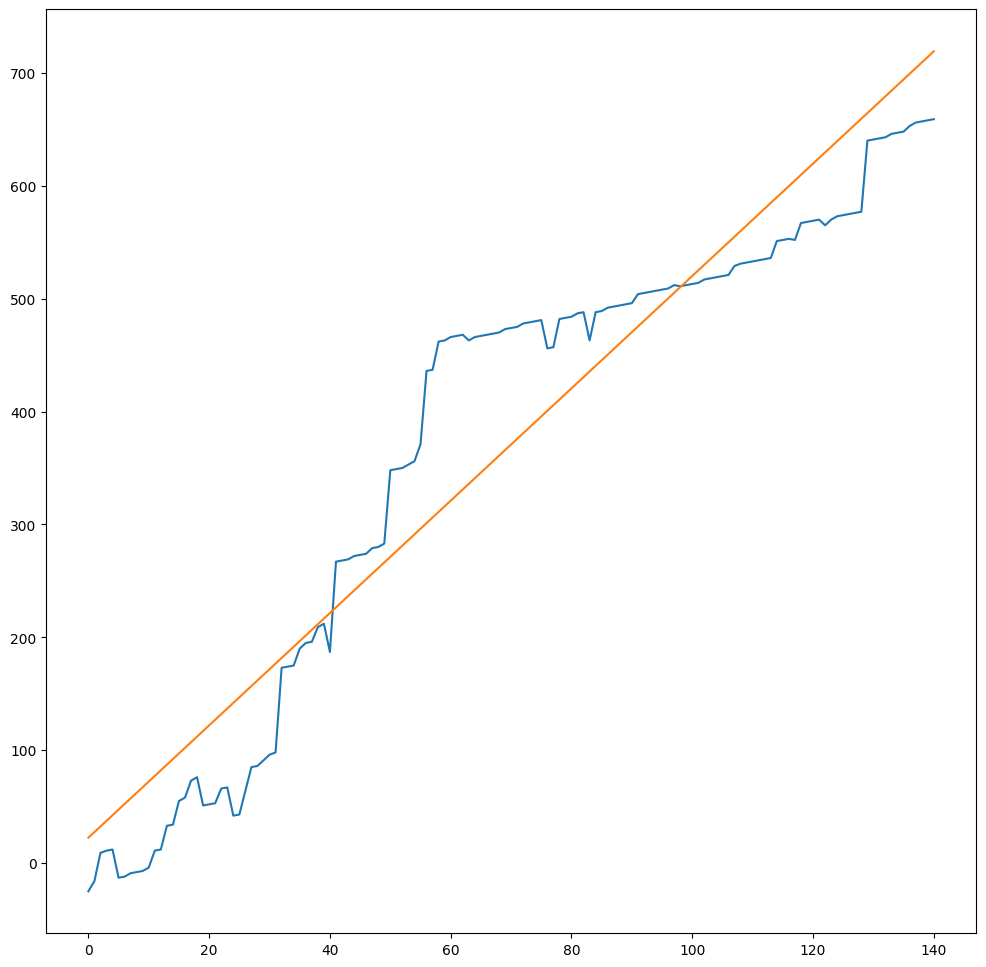

In [31]:
import random
import math
import copy
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    #random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles()    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[(i,j), 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]
    self.updateActual()
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 6) for i in range(6)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio...")      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria...")      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada("hint") #self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.updateActual(); self.showGame(); continue;
      coordinates = (lambda l: (int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])))(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
    print("Partida terminada, GG:\U0001F44F")
    self.plotScore()

  def getHint(self):
    prevObjs = sum(4 - self.objects[b][1] for a in self.matrix for b in a if b!=".")
    tempValues=[-math.inf, (0,0)]
    #debugValues = [[0]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): 
          newObj = copy.deepcopy(g)
          newObj.updateMatrix((i,j))
          newScore = sum(sum(self.objects[b][1] - 4*(b != "." or 0) for b in a) for a in newObj.matrix) + prevObjs - 10*newObj.minDistanceToElement((i,j), ["1", "2", newObj.matrix[i][j]])
          if newScore>tempValues[0]: tempValues = [newScore, (i,j)]
          #debugValues[i][j] = newScore
    #plt.imshow(debugValues, cmap='hot', interpolation='nearest')
    #plt.show()
    return tempValues[1]
  
  def plotScore(self):
    x = np.array(list(range(len(self.score))))
    m,c = self.linReg(x, self.score)
    fig = plt.figure(figsize=(12, 12))
    plt.plot(x, self.score)
    plt.plot(x, m*x + c)
    plt.show()
  
  def linReg(self, x, y):
    return np.linalg.lstsq(np.vstack([x, np.ones(len(x))]).T, y)[0]

  def minDistanceToElement(self, coordinates, elements):
    visited = set()
    q = [(coordinates, 0)]
    while q:
        n, distance = q.pop(0)
        if n in visited:
            continue
        visited.add(n)
        for i, j in ((n[0]-1, n[1]), (n[0]+1, n[1]), (n[0], n[1]-1), (n[0], n[1]+1)):
            if i < 0 or i >= len(self.matrix) or j < 0 or j >= len(self.matrix[0]): continue
            if self.matrix[i][j] in elements: return distance+1
            q.append(((i,j), distance+1))
    return 0   
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*6+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(((n[0][0]-1, n[0][1]), (n[0][0], n[0][1]+1), (n[0][0]+1, n[0][1]), (n[0][0], n[0][1]-1))):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    visited = set()
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      visited.add(n)
      for i in ((n[0]-1, n[1]), (n[0], n[1]+1), (n[0]+1, n[1]), (n[0], n[1]-1)):
        if i[0] < 0 or i[0] >= len(self.matrix) or i[1] < 0 or i[1] >= len(self.matrix[0]): continue
        if (not i in visited) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":
  g = MainGame()
  g.main()  

**Bot Encoding**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import random
import numpy as np
from collections import deque

BATCH_SIZE = 50

class QNet(nn.Module):
    def __init__(self, input_size=37, hidden_size=62, output_size=36):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        x = F.leaky_relu(self.linear4(x))
        x = F.leaky_relu(self.linear5(x))
        x = F.softmax(self.linear6(x))
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)
        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)
        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))
            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()

class Agent:
    def __init__(self):
        self.nGames = 0        
        self.memory = deque(maxlen=100000)
        self.model = QNet()
        self.trainer = QTrainer(self.model, lr=0.0012, gamma=0.9)

    def get_state(self, game):        
        return np.array([ord(i) for i in np.array(game.matrix).reshape(36).tolist()]+[ord(game.actual)])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory
        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state, matrix, actual):
        prediction = self.model(torch.tensor(state, dtype=torch.float))
        for i in range(len(matrix)):
          for j in range(len(matrix[0])):
            prediction[6*i+j]*=((matrix[i][j]==".") ^ (actual=="w"))
        
        final_move = torch.argmax(prediction).item()
        final_move = [final_move//6 if final_move!=36 else 5, final_move%6] 
        return final_move

def train():
    total_score = 0
    record = 0
    agent = Agent()
    game = MainGame()
    while True:
        state_old = agent.get_state(game)
        coordinates = tuple(agent.get_action(state_old, game.matrix, game.actual))
        # perform move and get new state
        reward = sum(game.objects[j][1] for i in game.matrix for j in i)
        game.updateMatrix(coordinates)
        game.updateActual()
        game.turn+=1
        game.bigFoots = [[i[0], i[1]+1, i[2]] for i in game.bigFoots]
        game.score.append(sum(game.objects[j][1] for i in game.matrix for j in i))
        reward = game.score[-1]-reward+game.linReg(np.array(list(range(len(game.score)))), game.score)[0]*len(game.score)        
        done = not (any("." in x for x in game.matrix))
        state_new = agent.get_state(game)

        agent.train_short_memory(state_old, coordinates, reward, state_new, done)
        agent.remember(state_old, coordinates, reward, state_new, done)

        if done:
            if agent.nGames%4 == 0:
              game.showGame()
              game.plotScore()  
            # train long memory, plot result, RESET GAME
            random.seed()
            game.checkAndLoadFiles()
            game.turn = 0
            game.score = []
            game.bigFoots = [[(i,j), 0, False] for i in range(len(game.matrix)) for j in range(len(game.matrix[0])) if game.matrix[i][j]=="1"]
            game.updateActual()
            
            agent.nGames += 1
            agent.train_long_memory()
            agent.model.save()

            print('Game', agent.nGames, 'Record:', record)

if __name__ == '__main__':
    train()